# 텍스트 클러스터링

## 1. 데이터 로드

In [2]:
# 데이터 로드
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

README.md:   0%|          | 0.00/617 [00:00<?, ?B/s]

c:\Users\heian\anaconda3\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\heian\.cache\huggingface\hub\datasets--maartengr--arxiv_nlp. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. Fo

data.csv:   0%|          | 0.00/53.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
dataset

Dataset({
    features: ['Titles', 'Abstracts', 'Years', 'Categories'],
    num_rows: 44949
})

In [4]:
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

## 2. 임베딩 생성

In [8]:
from sentence_transformers import SentenceTransformer

#초록에 대한 임베딩 생성
embedding_model = SentenceTransformer("thenlper/gte-small")
embeddings = embedding_model.encode(abstracts, show_progress_bar = True)
embeddings.shape

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

c:\Users\heian\anaconda3\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\heian\.cache\huggingface\hub\models--thenlper--gte-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

(44949, 384)

## 3. 임베딩 차원 축소

In [9]:
from umap import UMAP

# 입력 임베딩 차원축소 (384-> 5)
umap_model = UMAP(
                    n_components = 5, 
                    min_dist = 0.0, 
                    metric= 'cosine', 
                    random_state=42
                )
reduced_embeddings = umap_model.fit_transform(embeddings)
reduced_embeddings.shape

c:\Users\heian\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(44949, 5)

## 4. 임베딩 클러스터링 
- 밀도기반(density-based) 클러스터링 모델, HDBSCAN 사용

    - 장점 
        1) 클러스터의 개수를 자유롭게 설정
        2) 모든 데이터 포인트를 클러스터에 할당하지 않음 > 이상치 감지 가능

In [10]:
from hdbscan import HDBSCAN

# 모델 훈련 > 클러스터 추출
hdbscan_model = HDBSCAN(min_cluster_size=50).fit(reduced_embeddings)
clusters = hdbscan_model.labels_

#클러스터 개수 확인
len(set(clusters))

c:\Users\heian\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\heian\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


147

## 5. 클러스터 확인

In [28]:
import numpy as np

# 특정 클러스터에 있는 n개 문서 출력
cluster_idx = 0
show_doc_cnt = 3
for index in np.where(clusters==cluster_idx)[0][:show_doc_cnt]:
    print(abstracts[int(index)][:300],"... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo ... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang ... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf ... 



## 6. 클러스터 시각화

- 시각화를 위해 2차원으로 차원축소 필요

In [30]:
import pandas as pd

# 차원축소 (384차원 > 2차원)
reduced_embeddings = UMAP(
                        n_components=2,
                        min_dist =0.0,
                        metric="cosine",
                        random_state =42                  
                        ).fit_transform(embeddings)

# 데이터 프레임 생성
df = pd.DataFrame(reduced_embeddings, columns = ["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

clusters_df = df.loc[df.cluster !='-1', :]
outliers_df = df.loc[df.cluster =='-1', :]



c:\Users\heian\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(-7.276952409744263,
 11.704107904434204,
 -8.066553497314453,
 11.226025009155274)

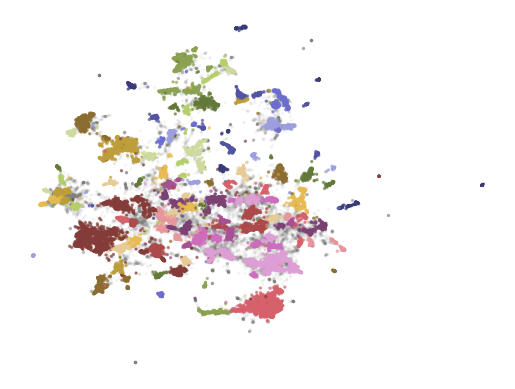

In [32]:
import matplotlib.pyplot as plt

# 그래프에 시각화(이상치, 정상치)
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int),
    alpha=0.6, s=2, cmap= 'tab20b'
)

plt.axis("off")